In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

In [3]:
#reading the dataset and the file saved in the directory
exchange_data = pd.read_csv('forex_data_10y.csv')
exchange_data.head()

,Date,Price,Open,High,Low,Volume,Chg%
0,25-Aug-20,74.327,74.100,74.335,74.075,0.92K,0.22%
1,24-Aug-20,74.168,74.922,74.922,73.962,4.90K,-1.01%
2,23-Aug-20,74.922,74.922,74.922,74.922,0,0.00%
3,21-Aug-20,74.920,74.980,75.005,74.820,3.16K,-0.12%
4,20-Aug-20,75.012,74.973,75.132,74.935,3.70K,0.22%


In [4]:
exchange_data["Date"] = pd.to_datetime(exchange_data["Date"])
ind_exchange_data = exchange_data.set_index(["Date"], drop=True)

In [5]:
#checking first few records of data set
ind_exchange_data.head()

,Price,Open,High,Low,Volume,Chg%
Date,,,,,,
2020-08-25,74.327,74.100,74.335,74.075,0.92K,0.22%
2020-08-24,74.168,74.922,74.922,73.962,4.90K,-1.01%
2020-08-23,74.922,74.922,74.922,74.922,0,0.00%
2020-08-21,74.920,74.980,75.005,74.820,3.16K,-0.12%
2020-08-20,75.012,74.973,75.132,74.935,3.70K,0.22%


In [6]:
# sorting the dataset in ascending order of date
data_frame = ind_exchange_data.sort_index(axis=1 ,ascending=True)
data_frame = data_frame.iloc[::-1]
data_frame.head()

,Chg%,High,Low,Open,Price,Volume
Date,,,,,,
2010-09-13,0.05%,46.415,46.100,46.220,46.310,0
2010-09-14,-0.09%,46.465,46.070,46.270,46.270,0
2010-09-15,-0.15%,46.460,46.080,46.160,46.200,0
2010-09-16,-0.12%,46.415,46.075,46.145,46.145,0
2010-09-17,-0.63%,46.128,45.785,46.085,45.855,0


<AxesSubplot:xlabel='Date'>

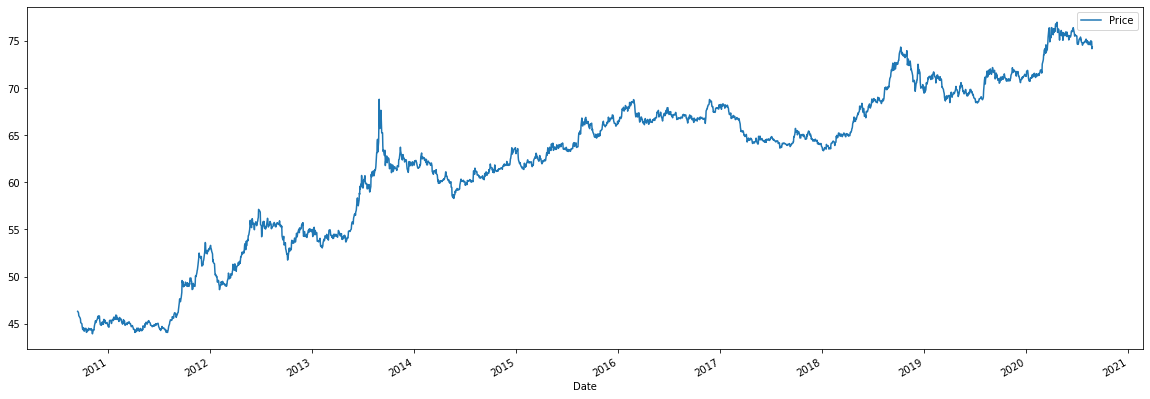

In [7]:

df = data_frame[["Price"]]


#plotting dataset to visualise the pattern of prices over r the years 
df.plot(kind='line',figsize=(20,7))

In [8]:
diff = df.index.values[-1] - df.index.values[0]
days = diff.astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')
years = int(days/365)
print("Total data: %d years"%years)
print("80 percent data = 2010 to %d"%(2010 + int(0.8*years)))


Total data: 9 years
80 percent data = 2010 to 2017


In [9]:
df.describe()

,Price
count,2598.000000
mean,61.972875
std,8.449870
min,43.925000
25%,55.460000
50%,64.017500
75%,67.836500
max,76.975000


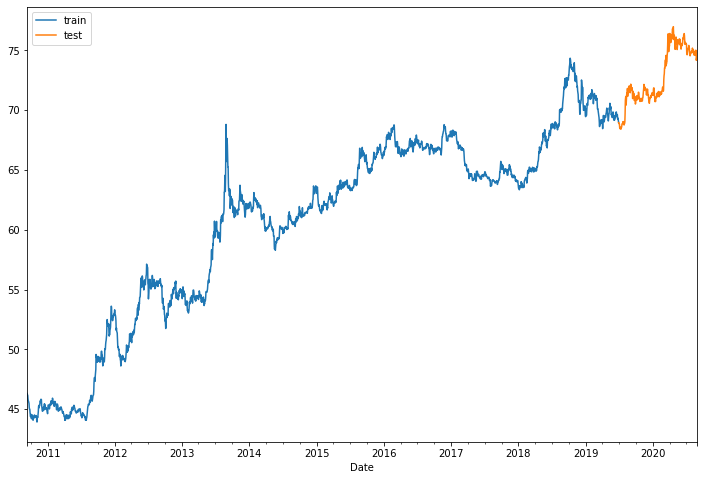

In [10]:
#Train Test Split 

#split the date of the csv file 
split_date = pd.Timestamp('28-06-2019')

#split the training and the testing accordingly with the split date 
train = df.loc[:split_date]
test = df.loc[split_date:]

ax = train.plot(kind='line', figsize=(12,8))
test.plot(ax=ax,kind='line',figsize=(12,8))
plt.legend(['train', 'test'])

In [11]:
#Start Data Normalization

from sklearn.preprocessing import StandardScaler


In [12]:
sc = StandardScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [13]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [14]:
X_train

array([[-1.79952061],
       [-1.8045777 ],
       [-1.81342762],
       ...,
       [ 1.11134249],
       [ 1.10009046],
       [ 1.08024137]])

In [15]:
#Artificial Neural Network

K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim =1, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                24        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(loss=tf.keras.metrics.mean_squared_error, 
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], 
              optimizer='adam')

early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)

history = model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/200
2294/2294 [==============================] - 1s 484us/step - loss: 0.4226 - rmse: 0.6501
Epoch 2/200
2294/2294 [==============================] - 1s 491us/step - loss: 0.0094 - rmse: 0.0971
Epoch 3/200
2294/2294 [==============================] - 1s 489us/step - loss: 0.0017 - rmse: 0.0415
Epoch 4/200
2294/2294 [==============================] - 1s 486us/step - loss: 0.0017 - rmse: 0.0411
Epoch 5/200
2294/2294 [==============================] - 1s 483us/step - loss: 0.0018 - rmse: 0.0419
Epoch 6/200
2294/2294 [==============================] - 1s 487us/step - loss: 0.0018 - rmse: 0.0424
Epoch 00006: early stopping


In [17]:
#ANN Prediction


y_pred_test = model.predict(X_test)
y_train_pred = model.predict(X_train)

train_mse = metrics.mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(test_mse)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("The  MAE on the Train set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred)))

print("The  RMSE on the Train set is:\t{:0.3f}".format(rmse_train))
r2_train = r2_score(y_train, y_train_pred)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test)))
r2_test = r2_score(y_test, y_pred_test)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))


inversed = sc.inverse_transform(y_pred_test)
inversed_date =  sc.inverse_transform(X_test)



print(inversed)







The R2 score on the Train set is:	0.972
The  MAE on the Train set is:	0.151
The  RMSE on the Train set is:	0.167
The Adjusted R2 score on the Train set is:	0.972

The R2 score on the Test set is:	0.468
The Adjusted R2 score on the Test set is:	0.466
The  MAE on the Test set is:	0.182
The  RMSE on the Test set is:	0.215
[[69.08531 ]
 [69.04597 ]
 [69.048996]
 [68.99452 ]
 [68.82928 ]
 [68.78267 ]
 [68.85288 ]
 [68.85228 ]
 [68.76391 ]
 [68.75846 ]
 [68.84925 ]
 [68.84017 ]
 [68.903725]
 [69.02236 ]
 [69.02781 ]
 [69.03084 ]
 [69.073204]
 [69.13555 ]
 [69.10347 ]
 [69.140396]
 [69.042946]
 [68.96728 ]
 [69.03205 ]
 [69.03992 ]
 [69.12587 ]
 [69.539276]
 [70.217804]
 [70.350365]
 [70.41392 ]
 [69.97508 ]
 [70.28015 ]
 [70.49745 ]
 [70.57916 ]
 [70.49261 ]
 [70.81644 ]
 [70.419975]
 [70.59914 ]
 [70.658455]
 [70.59187 ]
 [70.88907 ]
 [70.636665]
 [70.94657 ]
 [70.65482 ]
 [70.827934]
 [70.743805]
 [70.60035 ]
 [70.912674]
 [71.03434 ]
 [70.92478 ]
 [70.88786 ]
 [70.71656 ]
 [70.797066]
 [7

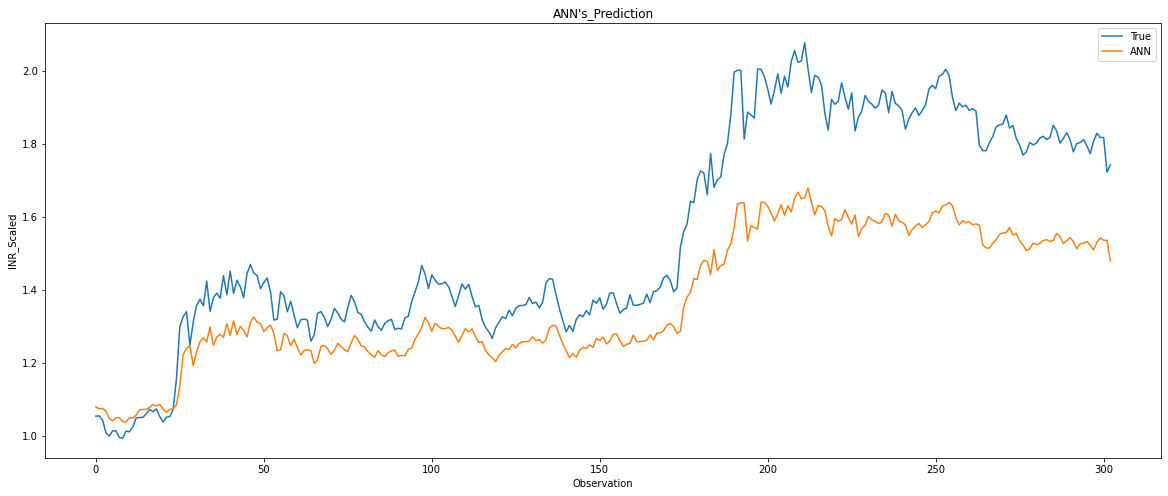

In [18]:
#ANN Prediction Plot

plt.figure(figsize=(20,8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test, label='ANN')
plt.title("ANN's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [25]:
# Data preprocessing for LSTM 

X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [26]:
#LSTM 

from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [27]:
model_lstm.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
2306/2306 [==============================] - 2s 712us/step - loss: 0.0125 - rmse: 0.1117
Epoch 2/100
2306/2306 [==============================] - 2s 714us/step - loss: 0.0015 - rmse: 0.0391
Epoch 3/100
2306/2306 [==============================] - 2s 711us/step - loss: 0.0015 - rmse: 0.0391
Epoch 4/100
2306/2306 [==============================] - 2s 701us/step - loss: 0.0015 - rmse: 0.0392
Epoch 5/100
2306/2306 [==============================] - 2s 699us/step - loss: 0.0015 - rmse: 0.0392
Epoch 6/100
2306/2306 [==============================] - 2s 714us/step - loss: 0.0016 - rmse: 0.0395
Epoch 7/100
2306/2306 [==============================] - 2s 713us/step - loss: 0.0016 - rmse: 0.0396
Epoch 00007: early stopping


In [28]:
y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)

train_mse = metrics.mean_squared_error(y_train, y_train_pred_lstm)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(y_test, y_pred_test_lstm)
rmse_test = np.sqrt(test_mse)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The  MAE on the Train set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred_lstm)))

print("The  RMSE on the Train set is:\t{:0.3f}".format(rmse_train))
r2_train = r2_score(y_train, y_train_pred_lstm)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test_lstm)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

The R2 score on the Train set is:	0.982
The  MAE on the Train set is:	0.124
The  RMSE on the Train set is:	0.135
The Adjusted R2 score on the Train set is:	0.982

The R2 score on the Test set is:	0.527
The Adjusted R2 score on the Test set is:	0.525
The  MAE on the Test set is:	0.167
The  RMSE on the Test set is:	0.202


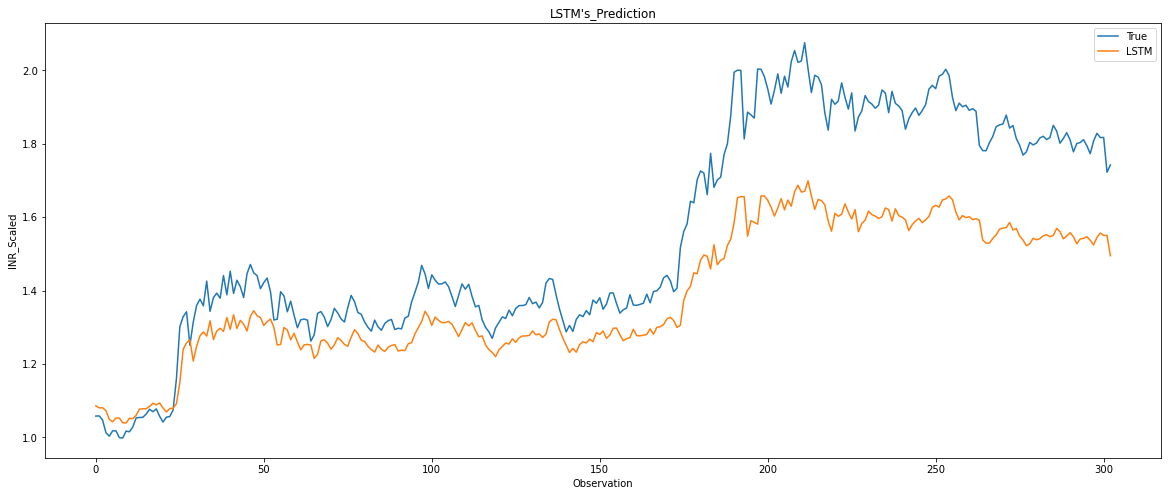

In [29]:
plt.figure(figsize=(20,8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [30]:
from keras.layers import GRU
K.clear_session()
model_gru = Sequential()
model_gru.add(GRU(7, input_shape=(1, X_train.shape[1]), activation='linear', kernel_initializer='lecun_uniform', return_sequences=False))
model_gru.add(Dense(1))
model_gru.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 7)                 210       
_________________________________________________________________
dense (Dense)                (None, 1)                 8         
Total params: 218
Trainable params: 218
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_gru.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)
history_model_gru = model_gru.fit(X_tr_t, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
2306/2306 [==============================] - 2s 679us/step - loss: 0.0343 - rmse: 0.1853
Epoch 2/100
2306/2306 [==============================] - 2s 664us/step - loss: 0.0025 - rmse: 0.0498
Epoch 3/100
2306/2306 [==============================] - 2s 663us/step - loss: 0.0019 - rmse: 0.0437
Epoch 4/100
2306/2306 [==============================] - 2s 664us/step - loss: 0.0016 - rmse: 0.0401
Epoch 5/100
2306/2306 [==============================] - 2s 672us/step - loss: 0.0015 - rmse: 0.0384
Epoch 6/100
2306/2306 [==============================] - 2s 672us/step - loss: 0.0014 - rmse: 0.0378
Epoch 7/100
2306/2306 [==============================] - 2s 663us/step - loss: 0.0014 - rmse: 0.0375
Epoch 8/100
2306/2306 [==============================] - 2s 708us/step - loss: 0.0014 - rmse: 0.0375
Epoch 9/100
2306/2306 [==============================] - 2s 674us/step - loss: 0.0014 - rmse: 0.0374
Epoch 10/100
2306/2306 [==============================] - 2s 668us/step - loss: 0.0014 - rm

In [ ]:
y_pred_test_gru = model_gru.predict(X_tst_t)
y_train_pred_gru = model_gru.predict(X_tr_t)

train_mse = metrics.mean_squared_error(y_train, y_train_pred_gru)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(y_test, y_pred_test_gru)
rmse_test = np.sqrt(test_mse)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_gru)))
print("The  MAE on the Train set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred_gru)))

print("The  RMSE on the Train set is:\t{:0.3f}".format(rmse_train))
r2_train = r2_score(y_train, y_train_pred_gru)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_gru)))
r2_test = r2_score(y_test, y_pred_test_gru)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test_gru)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

In [ ]:

plt.figure(figsize=(20,20))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='GRU')
plt.title("GRU's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()